## Images size 

In [1]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


# Goal

The goal of this notebook is to calculate the **beam center** for all the apertures measured (0, 60, 120, 180, 240 and 300)

NB: This notebooks takes **the profile files** produced by the [profile](https://neutronimaging.ornl.gov/tutorials/imaging-notebooks/profile/linear-profile/) notebook.

<img src='static/screenshot_of_profile_file.png' />


## python import

In [2]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob
import platform

from ipywidgets import interactive
from IPython.core.display import HTML
from IPython.core.display import display

import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib notebook

/var/folders/t8/307ghqxx5djb28nl56mkmx7j90c0xy/T/ipykernel_97136/3262499421.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis/"


# User input 

In [3]:
if platform.node() == "mac113775":
    top_folder = "/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis/"
elif platform.system() == "Linux":
    top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"    
else:
    top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"

### set up base folder 

In [4]:
base_folder = top_folder + "/profiles/beam_center_for_all_apertures"
assert os.path.exists(base_folder)  # making sure the base folder exists

# Loading all the profiles data

The following profiles were used on all the data sets

<img src='static/vertical_profile.png' />
<img src='static/horizontal_profile.png' />

### retrieving list of files to load 

In [5]:
list_profile_files = glob.glob(base_folder + '/*.txt')
assert len(list_profile_files) > 0

## load profiles 

In [6]:
def cleaning_list_name_columns(list_name_columns):
    clean_list_name_columns = []
    for _index_column, _line in enumerate(list_name_columns):
        _line_no_space = _line.replace(" ", "")
        file_name, col_name = _line_no_space.split("->")
        various_part_of_file_name = file_name.split("/")
        clean_list_name_columns.append(various_part_of_file_name[-1])
    return clean_list_name_columns

# raw_data_dict = {'horizontal_profile.txt': {'profiles': {'0deg_30s_frames_OB_median.tif': [],
#                                                          '0deg_nbr1_30s_frames_OB_median.tif': [],
#                                                          ...},
#                                             'xaxis': []},
#                  'vertical_profile.txt': ...
#                 }

raw_data_dict = {}
total_number_of_fitting_step = 0

for _file in list_profile_files:
    
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=26)
    pd_metadata = pd.read_csv(_file, skiprows=5, nrows=19)
    list_names_of_columns = list(pd_metadata.columns)
    list_label_columns = list(pd_metadata.loc[:, list_names_of_columns[0]])
    clean_list_label_columns = cleaning_list_name_columns(list_label_columns)
    
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    
    _dict = {}
    for _index, _col_name in enumerate(list_names_of_columns[1:]):
        profile = np.asarray(pd_data.loc[:, _col_name])
        _dict[clean_list_label_columns[_index]] = profile
        total_number_of_fitting_step += 1
    
    raw_data_dict[base_file_name] = {'profiles': _dict,
                                     'xaxis': xaxis}

the **raw_data_dict** is a dictionary that contains the profiles for all those files and the xaxis (pixel position) 

In [7]:
#raw_data_dict

# fitting horizontal and vertical profiles

In [8]:
# we estimate the center position (initial parameter to the fitting algorithm)
estimated_center = {'horizontal_profile.txt': 4456,    # 4456
                    'vertical_profile.txt': 2912}

In [9]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

progress_bar = widgets.IntProgress()
progress_bar.max = total_number_of_fitting_step
display(progress_bar)

master_profile_fitted_dict = {}
for _profile_type in raw_data_dict.keys():
    # _key being the profile file name
    
    xaxis = raw_data_dict[_profile_type]['xaxis']
   
    profile_dict = {}
    for _aperture_filename in raw_data_dict[_profile_type]['profiles'].keys():
    
        yaxis = raw_data_dict[_profile_type]['profiles'][_aperture_filename]

        pars = mod.make_params(c=yaxis.mean(),
                      center=estimated_center[_profile_type],
                      sigma=xaxis.std(),
                      amplitude=xaxis.std() * yaxis.ptp())
        out = mod.fit(yaxis, pars, x=xaxis)

        profile_dict[_aperture_filename] = {'center_value': round(out.params['center'].value),
                                            'center_error': out.params['center'].stderr,
                                            'fitting': out.best_fit,
                                            }
        
        progress_bar.value += 1
    
    master_profile_fitted_dict[_profile_type] = profile_dict

progress_bar.close()
print("Fitting done!")

IntProgress(value=0, max=38)

Fitting done!


## display the profiles fitted

The dictionary created by the fitting algorithm, called **master_profile_fitted_dict**, contains:
 * the fitting
 * the center value
 * the center value error

using the profile file name as a key

In [10]:
# master_profile_fitted_dict

In [17]:
fig, axes = plt.subplots(num=1, figsize=(8, 4), nrows=1, ncols=2)

def plot(aperture):

    aperture_file_name = aperture
    fig.suptitle(aperture)
   
    # horizontal
    axes[0].clear()
    horizontal_xaxis = raw_data_dict['horizontal_profile.txt']['xaxis']
    horizontal_yaxis = raw_data_dict['horizontal_profile.txt']['profiles'][aperture_file_name]
    fitted_horizontal_yaxis = master_profile_fitted_dict['horizontal_profile.txt'][aperture_file_name]['fitting']
    center_value = master_profile_fitted_dict['horizontal_profile.txt'][aperture_file_name]['center_value']
    axes[0].plot(horizontal_xaxis, horizontal_yaxis, '+')
    axes[0].plot(horizontal_xaxis, fitted_horizontal_yaxis, 'r')
    axes[0].axvline(center_value, color='green')
    axes[0].set_title("horizontal profile")

    # vertical
    axes[1].clear()
    vertical_xaxis = raw_data_dict['vertical_profile.txt']['xaxis']
    vertical_yaxis = raw_data_dict['vertical_profile.txt']['profiles'][aperture_file_name]
    fitted_vertical_yaxis = master_profile_fitted_dict['vertical_profile.txt'][aperture_file_name]['fitting']
    center_value = master_profile_fitted_dict['vertical_profile.txt'][aperture_file_name]['center_value']
    axes[1].plot(vertical_xaxis, vertical_yaxis, '+')
    axes[1].plot(vertical_xaxis, fitted_vertical_yaxis, 'r')
    axes[1].axvline(center_value, color='green')
    axes[1].set_title("vertical profile")

display_profiles = interactive(plot,
                              aperture = widgets.Dropdown(options=clean_list_label_columns))
display(display_profiles)
    
    
    

<IPython.core.display.Javascript object>

interactive(children=(Dropdown(description='aperture', options=('0deg_30s_frames_OB_median.tif', '0deg_nbr1_30…

## Let's plot the center of the beam found over the image 

In [12]:
base_folder = top_folder + "/median_data/"
list_images_to_load = [os.path.join(base_folder, _file) for _file in clean_list_label_columns]
assert len(list_images_to_load) > 0

In [13]:
progress_bar = widgets.IntProgress()
progress_bar.max = len(list_images_to_load)
display(progress_bar)

images = {}
for _image_filename in list_images_to_load:
    _key = os.path.basename(_image_filename)
    image = np.asarray(Image.open(_image_filename))
    images[_key] = image
    progress_bar.value += 1
    
progress_bar.close()
print("All images have been loaded!")

IntProgress(value=0, max=19)

All images have been loaded!


<IPython.core.display.Javascript object>


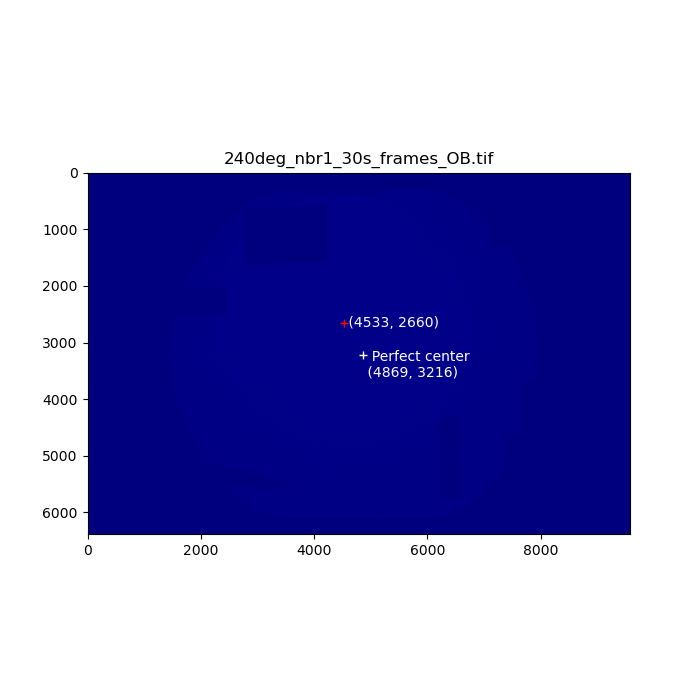

interactive(children=(Dropdown(description='filename', layout=Layout(width='500px'), options=('0deg_30s_frames…

In [14]:
perfect_center_x_px = 4869
perfect_center_y_px = 3216

figure = plt.figure(num='Visualize image center', figsize=(7, 7))

def plot_center(filename):
 
    center_x = master_profile_fitted_dict['horizontal_profile.txt'][filename]['center_value']
    center_x_error = master_profile_fitted_dict['horizontal_profile.txt'][filename]['center_error']
    center_y = master_profile_fitted_dict['vertical_profile.txt'][filename]['center_value']
    center_y_error = master_profile_fitted_dict['vertical_profile.txt'][filename]['center_error']
    
    image = images[filename]
    plt.cla()
    plt.title(filename)
    plt.imshow(image, cmap='jet')
    plt.plot(center_x, center_y, 'r+')
    plt.text(center_x, center_y,
             f" ({center_x}, {center_y})",
                     horizontalalignment='left',
             verticalalignment='center',
             color='white'
    )
    
    plt.plot(perfect_center_x_px, perfect_center_y_px, '+w')
    plt.text(perfect_center_x_px, perfect_center_y_px +400, f"  Perfect center\n ({int(perfect_center_x_px)}, " +
         f"{int(perfect_center_y_px)})", color="white")

    
#     plt.text(center_x+text_offset, center_y+text_offset,
#              f"x: {center_x} +/- {center_x_error:.2f}\ny: {center_y} +/- {center_y_error:.2f}",
#                      horizontalalignment='left',
#              verticalalignment='center',
#              color='white'
#     )

v = interactive(plot_center,
               filename = widgets.Dropdown(options=clean_list_label_columns,
                                          layout=widgets.Layout(width="500px")))
display(v)

## Let's display all the center at the same time (using 300deg image as a reference) 

In [15]:
def filename_starts_with(filename):
    split_filename = filename.split("_")
    return split_filename[0]

<IPython.core.display.Javascript object>


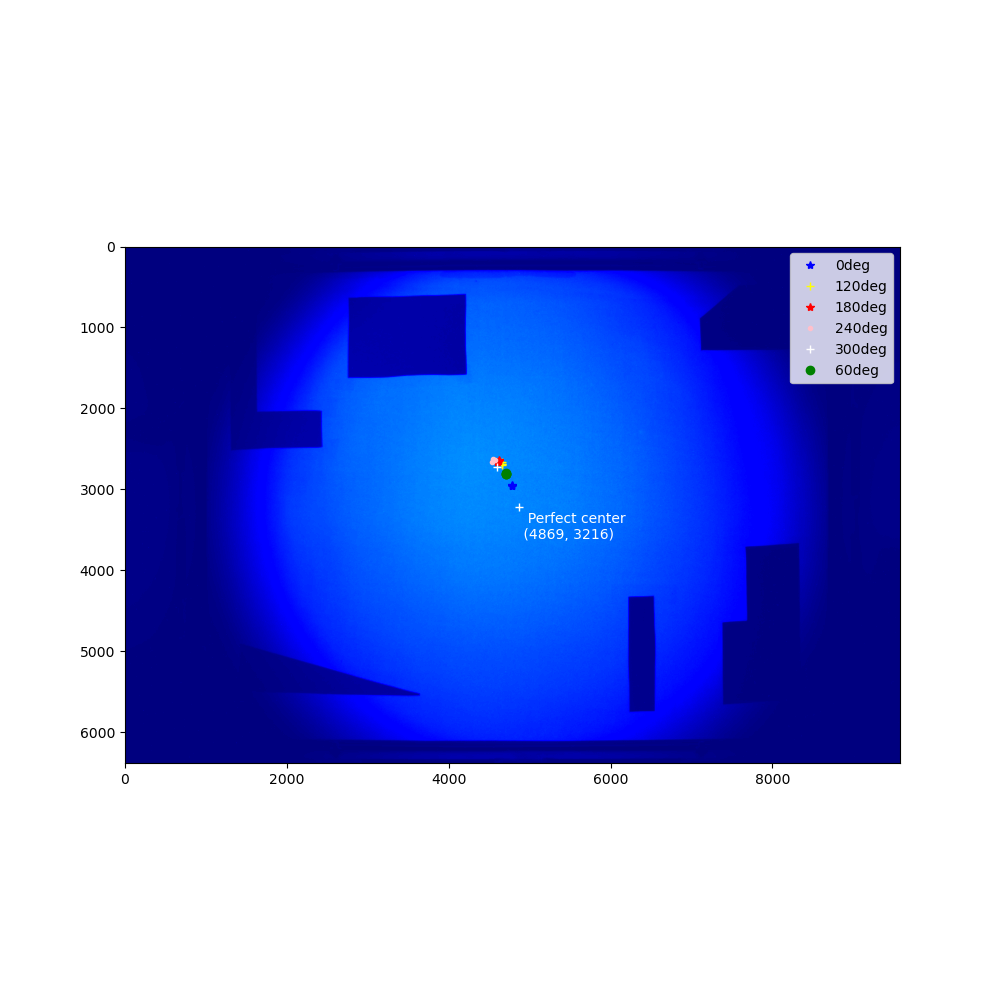

In [18]:
figure = plt.figure(num='Visualize ALL image centers', figsize=(10, 10))

filename = '300deg_nbr1_30s_frames_OB.tif'
image = images[filename]
plt.imshow(image, cmap='jet')

cursor_color = {'300deg': {'color': 'white',
                           'symbol': '+'},
                 '0deg': {'color':'blue',
                          'symbol': '*'},
                 '60deg': {'color': 'green',
                           'symbol': 'o'},
                 '120deg': {'color': 'yellow',
                            'symbol': '+'},
                 '180deg': {'color': 'red',
                            'symbol': '*'},
                 '240deg': {'color': 'pink',
                           'symbol': '.'},
                          }
aperture_label_used = {'300deg': False,
                       '0deg': False,
                       '60deg': False,
                       '120deg': False,
                       '180deg': False,
                       '240deg': False}

for filename in clean_list_label_columns:
    center_x = master_profile_fitted_dict['horizontal_profile.txt'][filename]['center_value']
    center_y = master_profile_fitted_dict['vertical_profile.txt'][filename]['center_value']

    cursor_key = filename_starts_with(filename)
    if not aperture_label_used[cursor_key]:
        plt.plot(center_x, center_y, 
                 cursor_color[cursor_key]['symbol'],
                 color=cursor_color[cursor_key]['color'], 
                 label=cursor_key)
        aperture_label_used[cursor_key] = True
    else:
        plt.plot(center_x, center_y,
                 cursor_color[cursor_key]['symbol'],
                 color=cursor_color[cursor_key]['color'])

    plt.legend()

plt.plot(perfect_center_x_px, perfect_center_y_px, '+w')
plt.text(perfect_center_x_px, perfect_center_y_px +400, f"  Perfect center\n ({int(perfect_center_x_px)}, " +
     f"{int(perfect_center_y_px)})", color="white")

display(HTML('<span style="color:blue">Blue -> 0deg</span>'))
display(HTML('<span style="color:green">Green -> 60deg</span>'))
display(HTML('<span style="color:yellow">Yellow -> 120deg</span>'))
display(HTML('<span style="color:red">Red -> 180deg</span>'))
display(HTML('<span style="color:pink>Pink -> 240deg</span>"'))
display(HTML('<span style="color:black">White -> 300deg</span>'))

# calculate center of beam (px and mm) for all apertures 

In [23]:
master_profile_fitted_dict

{'horizontal_profile.txt': {'0deg_30s_frames_OB_median.tif': {'center_value': 4779,
   'center_error': 0.7610197562280188,
   'fitting': array([3451.63555039, 3453.91962023, 3456.20485824, ..., 4351.96585804,
          4349.28361903, 4346.60239269])},
  '0deg_nbr1_30s_frames_OB_median.tif': {'center_value': 4780,
   'center_error': 0.904412110140306,
   'fitting': array([3479.21497459, 3481.5560621 , 3483.89829803, ..., 4398.91534377,
          4396.18550015, 4393.45663654])},
  '0deg_nbr2_30s_frames_OB.tif': {'center_value': 4781,
   'center_error': 1.1538178973298876,
   'fitting': array([3460.88053228, 3463.14894156, 3465.4185321 , ..., 4365.22736332,
          4362.55166229, 4359.87699043])},
  '120deg_30s_frames_OB_median.tif': {'center_value': 4656,
   'center_error': None,
   'fitting': array([883.95004017, 884.61565569, 885.2810556 , ..., 958.78198085,
          958.14085709, 957.49951748])},
  '120deg_again_30s_frames_OB_median.tif': {'center_value': 4653,
   'center_error': N

In [31]:
# real position (mm) of mask1 and 2 (use to calibrate position of center of beam)
real_x1 = 33.969
real_y1 = 84.191

x1 = 4221.
y1 = 1586.

real_x2 = -70.698
real_y2 = -57.584

x2 = 6220.
y2 = 4332.

def x_position_in_real_space(x_position_in_pixel):
    real_x = (((real_x2 - real_x1)/(x2-x1))*(x_position_in_pixel - x1) + real_x1)
    return real_x

def y_position_in_real_space(y_position_in_pixel):
    real_y = (((real_y2 - real_y1)/(y2-y1))*(y_position_in_pixel - y1) + real_y1)
    return real_y

In [32]:
# working with horizontal 
horizontal_key = 'horizontal_profile.txt'
vertical_key = 'vertical_profile.txt'

list_files = master_profile_fitted_dict[horizontal_key].keys()

summary_centers_dict = {}
for _file in list_files:
    
    x_center_value = master_profile_fitted_dict[horizontal_key][_file]['center_value']
    y_center_value = master_profile_fitted_dict[vertical_key][_file]['center_value']
    
    x_center_value_mm = x_position_in_real_space(x_center_value)
    y_center_value_mm = y_position_in_real_space(y_center_value)
    
    summary_centers_dict[_file] = {'pixel': {'x': x_center_value,
                                            'y': y_center_value,
                                            },
                                   'mm': {'x': x_center_value_mm,
                                         'y': y_center_value_mm},
                                  }
        
        

In [33]:
summary_centers_dict

{'0deg_30s_frames_OB_median.tif': {'pixel': {'x': 4779, 'y': 2957},
  'mm': {'x': 4.752298649324665, 'y': 13.406759286234518}},
 '0deg_nbr1_30s_frames_OB_median.tif': {'pixel': {'x': 4780, 'y': 2955},
  'mm': {'x': 4.699938969484744, 'y': 13.51001857246905}},
 '0deg_nbr2_30s_frames_OB.tif': {'pixel': {'x': 4781, 'y': 2952},
  'mm': {'x': 4.647579289644824, 'y': 13.664907501820835}},
 '120deg_30s_frames_OB_median.tif': {'pixel': {'x': 4656, 'y': 2688},
  'mm': {'x': 11.192539269634818, 'y': 27.295133284777854}},
 '120deg_again_30s_frames_OB_median.tif': {'pixel': {'x': 4653, 'y': 2682},
  'mm': {'x': 11.349618309154579, 'y': 27.604911143481424}},
 '120deg_nbr1_30s_frames_OB.tif': {'pixel': {'x': 4653, 'y': 2697},
  'mm': {'x': 11.349618309154579, 'y': 26.830466496722508}},
 '120deg_nbr2_30s_frames_OB.tif': {'pixel': {'x': 4660, 'y': 2659},
  'mm': {'x': 10.98310055027514, 'y': 28.79239293517844}},
 '180deg_30s_frames_OB_median.tif': {'pixel': {'x': 4610, 'y': 2661},
  'mm': {'x': 13.601

# export as ASCII

In [37]:
data_frame = pd.DataFrame.from_dict(summary_centers_dict)

In [38]:
data_frame

,0deg_30s_frames_OB_median.tif,0deg_nbr1_30s_frames_OB_median.tif,0deg_nbr2_30s_frames_OB.tif,120deg_30s_frames_OB_median.tif,120deg_again_30s_frames_OB_median.tif,120deg_nbr1_30s_frames_OB.tif,120deg_nbr2_30s_frames_OB.tif,180deg_30s_frames_OB_median.tif,180deg_again_30s_frames_OB.tif,180deg_nbr1_30s_frames_OB.tif,180deg_nbr2_30s_frames_OB.tif,240deg_30s_frames_OB_median.tif,240deg_nbr1_30s_frames_OB.tif,240deg_nbr2_30s_frames_OB.tif,300deg_nbr1_30s_frames_OB.tif,60deg_30s_frames_OB_median.tif,60deg_again_30s_frames_OB_median.tif,60deg_nbr1_30s_frames_OB.tif,60deg_nbr2_30s_frames_OB_median.tif
pixel,"{'x': 4779, 'y': 2957}","{'x': 4780, 'y': 2955}","{'x': 4781, 'y': 2952}","{'x': 4656, 'y': 2688}","{'x': 4653, 'y': 2682}","{'x': 4653, 'y': 2697}","{'x': 4660, 'y': 2659}","{'x': 4610, 'y': 2661}","{'x': 4621, 'y': 2656}","{'x': 4600, 'y': 2667}","{'x': 4615, 'y': 2632}","{'x': 4549, 'y': 2621}","{'x': 4533, 'y': 2660}","{'x': 4573, 'y': 2635}","{'x': 4593, 'y': 2726}","{'x': 4707, 'y': 2810}","{'x': 4706, 'y': 2808}","{'x': 4702, 'y': 2801}","{'x': 4706, 'y': 2812}"
mm,"{'x': 4.752298649324665, 'y': 13.406759286234518}","{'x': 4.699938969484744, 'y': 13.51001857246905}","{'x': 4.647579289644824, 'y': 13.664907501820835}","{'x': 11.192539269634818, 'y': 27.295133284777...","{'x': 11.349618309154579, 'y': 27.604911143481...","{'x': 11.349618309154579, 'y': 26.830466496722...","{'x': 10.98310055027514, 'y': 28.79239293517844}","{'x': 13.601084542271138, 'y': 28.689133648943...","{'x': 13.025128064032018, 'y': 28.947281864530...","{'x': 14.124681340670335, 'y': 28.379355790240...","{'x': 13.339286143071536, 'y': 30.186393299344...","{'x': 16.795025012506255, 'y': 30.754319373634...","{'x': 17.632779889944974, 'y': 28.74076329206118}","{'x': 15.538392696348176, 'y': 30.031504369992...","{'x': 14.491199099549775, 'y': 25.33320684632192}","{'x': 8.522195597798902, 'y': 20.99631682447196}","{'x': 8.574555277638822, 'y': 21.09957611070648}","{'x': 8.7839939969985, 'y': 21.460983612527315}","{'x': 8.574555277638822, 'y': 20.893057538237436}"
